In [1]:
import kwant
import tinyarray
import numpy as np
import matplotlib.pyplot as plt

/home/nssd/miniconda3/envs/kwant-env/lib/python3.11/site-packages/kwant/lattice.py:746: KwantDeprecationWarning: Not specfying norbs is deprecated. Always specify norbs when creating site families.
  return Monatomic(((a, 0), (0, a)), name=name, norbs=norbs)


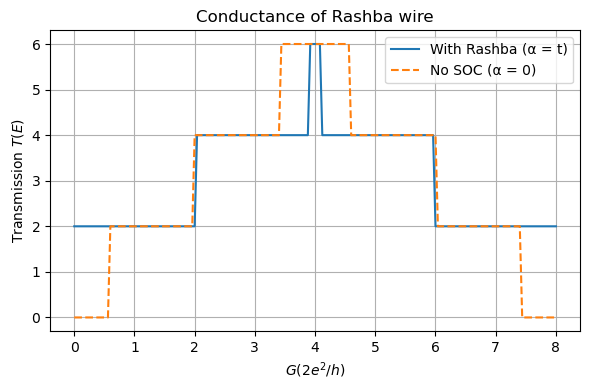

In [3]:
sigma0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])

t = 1.0 #hopping
L = 3  # length
W = 3  # width
lat = kwant.lattice.square()

def make_system(alpha):
    sys = kwant.Builder()

    # CENTRAL Region
    for x in range(L):
        for y in range(W):
            sys[lat(x, y)] = 4 * t * sigma0
            if x > 0:
                sys[lat(x, y), lat(x - 1, y)] = -t * sigma0 - 1j * alpha * sigma_y
            if y > 0:
                sys[lat(x, y), lat(x, y - 1)] = -t * sigma0 + 1j * alpha * sigma_x

    # Leads (left and right)
    for direction in [-1, 1]:
        sym = kwant.TranslationalSymmetry((direction, 0))
        lead = kwant.Builder(sym)
        for y in range(W):
            lead[lat(0, y)] = 4 * t * sigma0
            if y > 0:
                lead[lat(0, y), lat(0, y - 1)] = -t * sigma0 + 1j * alpha * sigma_x
            lead[lat(1, y), lat(0, y)] = -t * sigma0 - 1j * alpha * sigma_y
        sys.attach_lead(lead)

    return sys.finalized()

syst_noSOC = make_system(alpha=0.0)
syst_withSOC = make_system(alpha=1.0)

energies = np.linspace(0, 8, 201)
T_noSOC = []
T_withSOC = []

for E in energies:
    smatrix_no = kwant.smatrix(syst_noSOC, E)
    smatrix_so = kwant.smatrix(syst_withSOC, E)
    T_noSOC.append(smatrix_no.transmission(1, 0))
    T_withSOC.append(smatrix_so.transmission(1, 0))

plt.figure(figsize=(6, 4))
plt.plot(energies, T_withSOC, label="With Rashba (α = t)")
plt.plot(energies, T_noSOC, '--', label="No SOC (α = 0)")
plt.xlabel("$G (2e^2/h)$")
plt.ylabel("Transmission $T(E)$")
plt.legend()
plt.title("Conductance of Rashba wire")
plt.grid(True)
plt.tight_layout()
plt.show()

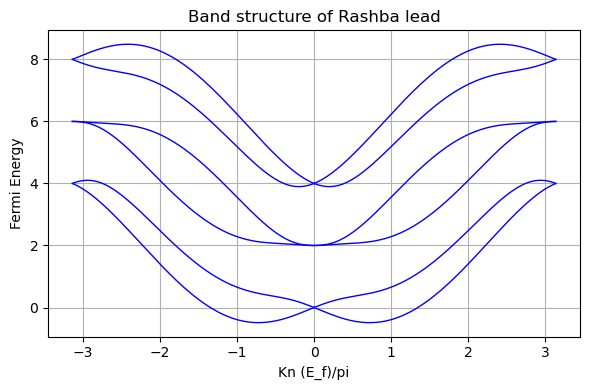

In [4]:
lead = syst_withSOC.leads[0]
bands = kwant.physics.Bands(lead)

ks = np.linspace(-np.pi, np.pi, 200)
band_energies = np.array([bands(k) for k in ks]) 

plt.figure(figsize=(6, 4))
for band_index in range(band_energies.shape[1]):
    plt.plot(ks, band_energies[:, band_index].real, color='b', linewidth=1)

plt.xlabel("Kn (E_f)/pi")
plt.ylabel("Fermi Energy")
plt.title("Band structure of Rashba lead")
plt.grid(True)
plt.tight_layout()
plt.show()